# Finding a recipe to the "Secret Sauce" of Quantum Computing

### How quantum computers do more than classical ones

**What is the goal of this section?**

Our goal here is to explain what superposition is, how it differs from classical randomness, and why it enables quantum advantage.
And then, we will show how to *prove* when superposition is really present.


## Classical bit vs Quantum bit

A **classical bit** can be:
- `0`
- `1`

A **quantum bit (qubit)** can be:
$$ 
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle
 $$
where:
$$
|\alpha|^2 + |\beta|^2 = 1
$$

...and this is also known as a **superposition** of `|0⟩` and `|1⟩`.

(Note that a qubit can exist in *both* states at once until we measure it.)


## Intuition: Not just randomness

A coin flip is random, but a qubit is not just random because it has **phase** and **interference**.

A classical mixture will consist of a:
- 50% chance of 0
- 50% chance of 1

But a quantum superposition will have:
$$
|\psi\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}
$$
This looks like a coin flip when measured…
but behaves *very differently* when combined with other operations.


## ...but Superposition is not enough

At first glance, superposition already seems weirdly powerful:

$$
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle
$$

But there is a catch, because if we prepare two qubits independently, we obtain:

$$
(|0\rangle + |1\rangle) \otimes (|0\rangle + |1\rangle)
$$

Which upon closer inspection, still is only a product of two single-qubit states.

Such states can always be explained as:

• independent quantum systems  
• no non-classical correlations  
• efficiently simulable  

Which, unfortunately, means that superposition alone cannot explain quantum advantage.

So, it's about time we get to the sauce of all of this: Entanglement!

## From a superposition to entanglement

An entangled state is one that **cannot** be written as a product of individual qubit states, so for example:

$$
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

But there also exists no single-qubit states $|\psi_1\rangle$, $|\psi_2\rangle$ such that:

$$
|\Phi^+\rangle = |\psi_1\rangle \otimes |\psi_2\rangle
$$

Which means that the qubits do not have independent states, measurement outcomes that are correlated, and no classical randomness can reproduce the statistics, all definitions of what Einstein called *“spooky action at a distance.”*


## The experimental challenge

We shall now face the curmudgeon’s question:

> If I gave you a box of qubits, how do you know they are entangled?

Our task is to construct experiments whose outcomes cannot come from classical randomness & from separable quantum states, and must come ONLY from entangled quantum states

In other words, we must **certify entanglement from measurement data alone**. (or, that's what we aim to do, at least.)


## The first entanglement experiment: Bell states

We shall begin with the simplest nontrivial case of two qubits provided to us by IQM Quantum Computers:

$$
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

and then design measurements in accordance to this equation to show that the statistics it produces violate classical explanations and that its correlations cannot arise from separable states in order to scale up to larger-qubit systems.

In this state, each qubit individually appears random and the two qubits are perfectly correlated, but as a consequence this state **cannot** be written as a product:

$$
|\Phi^+\rangle \neq |\psi_1\rangle \otimes |\psi_2\rangle
$$

so our goal will have to be reached experimentally using only measurement data.

Our circuit will consist of a single Hadamard gate on qubit 0 to facilitate superposition and a CNOT gate to cause entanglement:

$$
|00\rangle \xrightarrow{H \otimes I} \frac{|00\rangle + |10\rangle}{\sqrt{2}}
\xrightarrow{\text{CNOT}} \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

In [1]:
# An IQM Token is needed to run all code blocks

from iqm.qiskit_iqm import IQMProvider

token = input("Enter your IQM token: ")

provider = IQMProvider(
    "https://resonance.meetiqm.com/",
    quantum_computer="emerald", 
    token=token
)

backend = provider.get_backend()
backend


In [18]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

qc


## Measurements in the Z basis

We will now use the previous simple circuit measure both qubits in the computational (Z) basis. If the state were separable, we would expect independent outcomes, so instead we will test for correlations.


In [19]:
from qiskit import transpile

qc_z = qc.copy()
qc_z.measure_all()

tqc_z = transpile(qc_z, backend=backend, optimization_level=3)
job_z = backend.run(tqc_z, shots=2000)
result_z = job_z.result()
counts_z = result_z.get_counts()

counts_z

{'11': 945, '00': 959, '10': 69, '01': 27}

The Z-basis results show near-perfect correlation between the two qubits (with a small amount of leakage into 01/10 from noise & readout errors), however, classical correlation alone is not sufficient to prove entanglement, which leads us to test coherence in a second basis.

## Measurements in the X basis & Correlations

We begin with using the same circuit in the X basis


In [20]:
qc_x = qc.copy()
qc_x.h(0)
qc_x.h(1)
qc_x.measure_all()

tqc_x = transpile(qc_x, backend=backend, optimization_level=3)
job_x = backend.run(tqc_x, shots=2000)
result_x = job_x.result()
counts_x = result_x.get_counts()

counts_x

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

{'00': 948, '11': 958, '10': 65, '01': 29}


We now compute the correlation observables:

$$
\langle Z_0 Z_1 \rangle, \quad \langle X_0 X_1 \rangle
$$

with:

In [21]:
def exp_zz(counts, shots=2000):
    total = 0
    for bitstring, c in counts.items():
        # rightmost bit = qubit 0 in Qiskit
        b0 = int(bitstring[-1])
        b1 = int(bitstring[-2])
        val = 1 if (b0 ^ b1) == 0 else -1
        total += val * c
    return total / shots

zz = exp_zz(counts_z)
xx = exp_zz(counts_x)

zz, xx

(0.904, 0.906)

For the Bell state, quantum theory will predict that

$$
\langle Z_0 Z_1 \rangle = 1, \quad \langle X_0 X_1 \rangle = 1.
$$

Which allows us to combine these into an entanglement *witness* as:

$$
W = \langle Z_0 Z_1 \rangle + \langle X_0 X_1 \rangle.
$$

For across all the separable two-qubit states:

$$
W \le 1.
$$


In [22]:
W = zz + xx
W


1.81

Since the measured value violates the separable bounds we've set, we may conclude that the qubits are entangled based only on measurement data, and that no assumption about state preparation was required. 

## The n-qubits entanglement experiment: GHZ Gate with a Stabilizer Witness


The intution starts off from the well-known bell states:
\begin{align*}
   |\phi^+\rangle &= \frac{|00\rangle + |11\rangle}{\sqrt{2}}\\
   |\phi^-\rangle &= \frac{|00\rangle - |11\rangle}{\sqrt{2}}\\
   |\psi^+\rangle &= \frac{|01\rangle + |10\rangle}{\sqrt{2}}\\
   |\psi^-\rangle &= \frac{|01\rangle - |10\rangle}{\sqrt{2}}\\
\end{align*}


These are the well-known double-qubit entangled superpositions. It can be shown that there does not exist single-qubit superpositions $|\psi_1\rangle,|\psi_2\rangle$ such that any of $|\phi^+\rangle, |\phi^-\rangle, |\psi^+\rangle$, and $|\psi^-\rangle$ can be factored into the form $|\psi_1\rangle \otimes |\psi_2\rangle$.


Specifically for $|\phi^+\rangle$ and $|\phi^-\rangle$, it is easy to see that the pattern can indefinitely extend to a higher number $n$ of qubits, as superpositions of the form
\begin{align*}
   \alpha|x^{\otimes n}\rangle + \beta|y^{\otimes n}\rangle
\end{align*}
where $n\in\mathbb{Z}$ such that $n \geq 2$, $|\alpha|^2 + |\beta|^2 = 1$, and $x$ and $y$ are states, can not be factored. That is, no qubit state, not even multi-qubit states, can be factored out.


The Greenberger–Horne–Zeilinger (GHZ) State is then of the form
\begin{align*}
   \frac{\left|0^{\otimes n}\right\rangle + \left|1^{\otimes n}\right\rangle}{\sqrt{2}}
\end{align*}
where $n$ is the number of qubits.

Our goal is to design a entanglement witness for GHZ scaling with system size to show that superpositions of this form are indeed entangled.

Fidelity is a measure of accuracy and reliability for resulting states from a superposition given errors. It is scaled between 0 and 1. The formula for Fidelity $F$ is:
\begin{align*}
F \geq \frac{1}{2}\left( \left\langle X^{\otimes N} \right\rangle + \frac{1}{N - 1}\sum_{i = 1}^{N - 1}\left\langle Z_iZ_{i + 1}\right\rangle\right)
\end{align*}
where $N$ is the total number of qubits used, $\frac{1}{N - 1}\sum_{i = 1}^{N - 1}\left\langle Z_iZ_{i + 1}\right\rangle$ is the average Z-basis measurement and $\left\langle X^{\otimes N} \right\rangle$ is the global coherence (X-basis measurement).

Let $\text{GHZ}_N$ be the GHZ quantum gate for $N$ qubits, where $\text{GHZ}_N\left|0^{\otimes N}\right\rangle = \frac{\left|0^{\otimes n}\right\rangle + \left|1^{\otimes n}\right\rangle}{\sqrt{2}}$.

Let $i\in\mathbb{Z}$ such that $0 \leq i \leq N - 1$. Then, $Z_i = 1$ if the $i$-th resulting qubit state is even (in binary representation). Otherwise, $Z_i = -1$. 

The code used to model our experimental fidelity & to conduct data collection is as shown:

In [ ]:
from iqm.qiskit_iqm import IQMProvider

from qiskit import QuantumCircuit, transpile, visualization

def getGhzCircuit(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    return qc

def getZZExpectation(counts, i, j, shots):
    exp = 0
    for bitstring, freq in counts.items():
        zi = 1 if bitstring[::-1][i] == '0' else -1
        zj = 1 if bitstring[::-1][j] == '0' else -1
        exp += zi * zj * freq
    return exp / shots

def getGlobalXExpectation(counts, shots):
    exp = 0
    for bitstring, freq in counts.items():
        bits = bitstring.replace(" ", "")
        parity = bits.count('1')
        value = 1 if parity % 2 == 0 else -1
        exp += value * freq
    
    return exp / shots

# The number of qubits used
qBits = 54

qcz = getGhzCircuit(qBits)
qcz.measure_all()

qcx = getGhzCircuit(qBits)
for i in range(qBits):
    qcx.h(i)
qcx.measure_all()

# Run the job for measuring with Z-basis
qc_transpiled1 = transpile(qcz, backend=backend)
job_z = backend.run(qc_transpiled1, shots=1024)
result_z = job_z.result()


# Run the job for measuring with X-basis
qc_transpiled2 = transpile(qcx, backend=backend)
job_x = backend.run(qc_transpiled2, shots=1024)
result_x = job_x.result()

# Writing data to external files
with open("zz_expectation.txt", 'w') as file1:
    # Calculate Z-basis measurement
    for i in range(qBits - 1):
        s = f"<Z{i}Z{i+1}>:\t {getZZExpectation(result_z.get_counts(), i, i+1, 1024)}\n"
        file1.write(f"{s}\n")

with open("x_expectations.txt", 'w') as file2:
    # Calculate X-basis measurement
    s = f"<X^prodN>:\t{getGlobalXExpectation(result_x.get_counts(), 1024)}"
    file2.write(f"{s}\n")

zz_sum = 0
with open("fidelity.txt", 'w') as file3:
    file3.write(f"GHZ Witness Fidelity Lower Bound with {qBits} qubits and 1024 shots\n\n\n")
    file3.write(f"zz_sum = {zz_sum}\n")

    # Calculate Fidelity 
    for i in range(qBits - 1):
        zz_sum += getZZExpectation(result_z.get_counts(), i, i + 1, 1024)
    file3.write(f"zz_sum = {zz_sum}\n")

    zz_avg = zz_sum / (qBits - 1)
    file3.write(f"\n\n\nzz_avg = {zz_avg}\n")

    x_val = getGlobalXExpectation(result_x.get_counts(), 1024)
    file3.write(f"\n\n\nx_val = {x_val}\n")

    # Fidelity
    fidelity_lb = 0.5 * (x_val + zz_avg)
    file3.write(f"\n\n\nfidelity lower bound = {fidelity_lb}\n")

NameError: name 'QuantumCircuit' is not defined

## Scaling behavior & Dataset

We measure the entanglement witness (or fidelity) as a function of the number of qubits N.

Observed below, the trend has an approximately linear decay that's consistent with an increasing circuit depth with a trend in accumulated gate error and readout noise, but nevertheless, for small and intermediate N we were able to certify multipartite entanglement due to the measured values exceeding the separable-state threshold.

<div style="display: flex; justify-content: center;">
   <img alt="Graph of GHZ Fidelity to the number of Qubits" src="./assets/GHZ_Fidelity_Graph3.png" width="800"/>
</div>
Here, the fidelity is plotted for increments of every 5 qubits starting from 5 to 50. The minimum number of qubits possible for a GHZ gate (2) and the maximum number of qubits available in the quantum computer (54) are also plotted.

The code used to generate the graph from a trial of the code above is below.

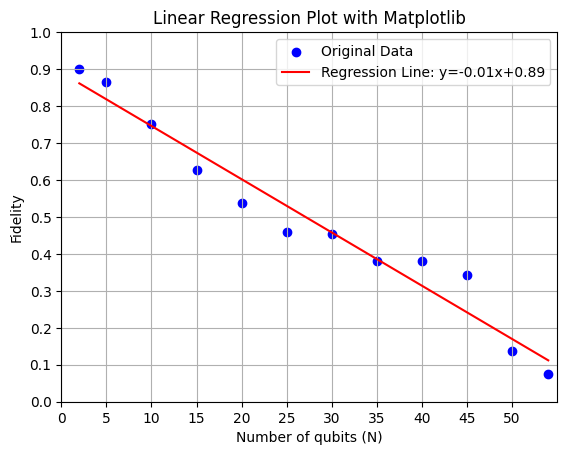

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    2: 0.8994140625,
    5: 0.8662109375,
    10: 0.7507595486111112,
    15: 0.6273716517857143,
    20: 0.5374177631578947,
    25: 0.4580891927083333,
    30: 0.4538995150862069,
    35: 0.38192210477941174,
    40: 0.3817858573717949,
    45: 0.3424627130681818,
    50: 0.13805404974489796,
    54: 0.07488207547169812
}

x = np.array([i for i in data.keys()])
y = np.array([i for i in data.values()])


m, b = np.polyfit(x, y, 1)
y_pred = m * x + b

plt.scatter(x, y, color='blue', label='Original Data')
plt.plot(x, y_pred, color='red', label=f'Regression Line: y={m:.2f}x+{b:.2f}')


plt.xlabel('Number of qubits (N)')
plt.ylabel('Fidelity')
plt.title('Linear Regression Plot with Matplotlib')
plt.legend()
plt.grid(True)


plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.01, 0.1))

plt.xlim(0, 55)
plt.xticks(np.arange(0, 55, 5))

plt.show()